## Numerical Implementation of Risk Management techniques

#### What is a risk measurement?
Glyn A. Holton (§1.2 - [2]) defines a risk measure as "an operation that asssigns a value to a risk" and a risk metric as "the attribute of risk that is being measured". Models such as the Markowitz model (presented in [1]) teach us that two equally rational investors may may follow dramatically different strategies when allocating their investments due to different risk appetites expressed as utility functions. With this in mind it is natural that investors should attempt to assign a numerical value to "worst-case scenario" type events, in order to make a rational decision for their own risk profile.

Many sources such as Jorion (§I.2, [3]) and Holton (§1.9, [3]), point to  the early 1990s as the origins of  the modern approach to risk measurement. They are a key fixture in financial regulation such as Basel II and III, and are designed to address concerns about how much capital financial institutions should hold in reserve to cover their exposures, especially in the emerging derivatives market at the time. 

We will be examining two of the most wide spread and intuitive methods for measuring risk. 

#### Value at Risk (VaR)
Value-at-Risk is a very intuitive risk measurement because it encapsulates the natural desire to consider the upper bound of one's losses over a given time period (at a certain confidence level). From John Armstrong (§8 [4]) we have a formal definition of VaR as:

$$\text{VaR}_{\alpha}(X) = \inf\{x \in \mathbb{R} : P(X < -x) \leq 1 - \alpha\}$$

Where $\alpha \in (0,1)$ expresses our desired confidence level.

##### Expected Shortfall
Very closely related is the concept of Expected Shortfall. It expresses our desire to know the average loss in scenarios outside of our confidence level. This is arguably a more useful figure as it capture more information about the lower tail of our distribution.

From John Armstrong( §8 [4]) we have a formal definition of VaR as:

$$ES_{\alpha}(X) = \frac{1}{\alpha} \int_{0}^{\alpha} VaR_{\gamma}(X) \, d\gamma$$


#### Selection of the underlying probability distribution
It should be noted that as with any probabilistic model these methods require us either to rely entire on historical data, so called "Historical VaR" ([4]) or to encode our own prior beliefs into the probability of losses occuring and infer from it a "Monte Carlo VaR" ([4]). 

In highly modern highly interconnected financial systems many crises have occured as a result of large participants struggling to accurately model their exposure to certain events, which are likely not given enough weighting in historical data especially when they are as a result of financial innovations such as CDOs in the 2008 financial crisis or high-frequency trading in the case of the 2010 "Flash Crash".

Most authors including Holton (§0.2 [2]) emphasise that without good data to rely on for the probabiltiy distribution these forms of models may provide a false sense of security leading to disasterous results. Holton gives the example of the 2008 financial crisis where many banks had a "Credit VaR" models in place despite a "paucity" of data on default rates in the products involved. These models proved to "fail spectacularly" as a result.

John Armstrong highlights that "Historical VaR" makes quite a crude assumption that "past results will predict the future" whereas it could be argued that "Black Swans" (Jorion, §1.1.1, [3]) are more common than we might predict from the limited data that we have on modern financial markets in the past 100 years .

To conclude, risks measures such as the ones presented are an effective tool for decision making, and provide a great deal of flexibility in allowing us to model potential outcomes in whichever we wish. However, they do not provide any guidance at all to how these outcomes should be modelled and here great caution should be exercised.

## Implementing Numerically

Given a portfolio of assets and derivatives we can attempt a numerical implementation of the risk metrics above by doing the following:

### 1. Simulate the evolution of underlying asset prices
This involves the selection and calibration of a model, for instance a Black-Scholes style geometric Brownian motion. If you have a view as to the correlation of the asset prices this can be incorporated using a cholesky decomposition of the covariance matrix to produce correlated price processes. A simulation using as many paths as feasible is desirable.

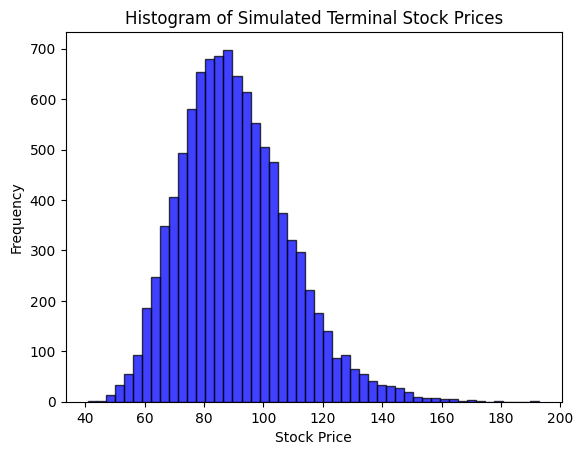

In [28]:
import numpy as np
from math import *
import matplotlib.pyplot as plt

def simulate_gbm(S0, mu, sigma, T, n_scenarios):
    dt = T
    Z = np.random.normal(0, 1, n_scenarios)
    ST = S0 * np.exp((mu - 0.5 * sigma**2) * dt + sigma * sqrt(dt) * Z)
    return ST

# Example usage
S0 = 100  # Initial stock price
mu = -0.1  # Drift
sigma = 0.2  # Volatility
T = 1  # Time horizon (1 year)
n_scenarios = 10000  # Number of scenarios

simulated_prices = simulate_gbm(S0, mu, sigma, T, n_scenarios)

# Plot histogram of simulated terminal prices
plt.hist(simulated_prices, bins=50, alpha=0.75, color='blue', edgecolor='black')
plt.title("Histogram of Simulated Terminal Stock Prices")
plt.xlabel("Stock Price")
plt.ylabel("Frequency")
plt.show()

### 2. Evaluate profit and loss scenarios at the desired time horizon
If the portfolio also contains derivatives the value of those derivatives at the VaR time horizon can calculated from the underlying in each specific scenario. If at the VaR time horizon derivatives have not yet matured they can be marked to market using a numerical pricing method (or analytically if the price process allows).

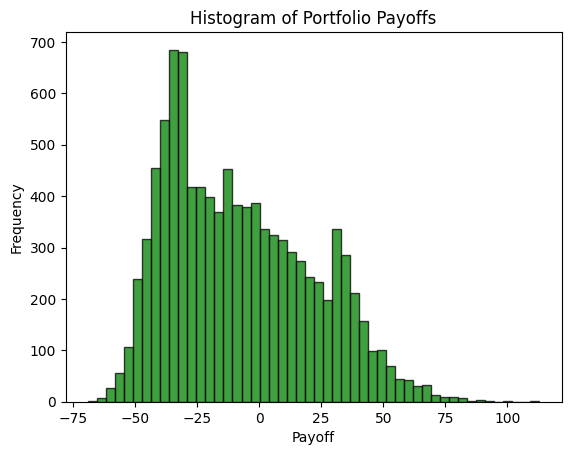

In [36]:
def option_payoff(simulated_prices, strike_price, option_type="call"):
    """
    Simulates the payoff of a call or put option.

    Parameters:
    simulated_prices (numpy.ndarray): Simulated terminal prices of the underlying asset.
    strike_price (float): Strike price of the option.
    option_type (str): Type of the option, either "call" or "put". Default is "call".

    Returns:
    numpy.ndarray: Payoff of the option for each simulated scenario.
    """
    if option_type == "call":
        payoff = np.maximum(simulated_prices - strike_price, 0)
    elif option_type == "put":
        payoff = np.maximum(strike_price - simulated_prices, 0)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")
    return payoff

# Example porfolio payoff -  long 1 call option, short 1 put option
call_option_payoff = option_payoff(simulated_prices, 80, option_type="call")
put_option_payoff = -option_payoff(simulated_prices, 110, option_type="put")

# Total portfolio payoff
portfolio_payoff = call_option_payoff + put_option_payoff
# Plot histogram of portfolio payoffs
plt.hist(portfolio_payoff, bins=50, alpha=0.75, color='green', edgecolor='black')
plt.title("Histogram of Portfolio Payoffs")
plt.xlabel("Payoff")
plt.ylabel("Frequency")
plt.show()

### 3. Numerically approximate the metrics
Once we have a vector containing profit & loss for each scenario, we can apply the formula above numerically. The VaR is calculated using numpy's percentile function, and the integral for expected shorfall can be approximated by a simple average

In [37]:
#returns the VaR and Expected Shortfall given vector of simulated P&L values and a confidence level alpha
def risk_measure(simulated_payoff,alpha):
    var = np.percentile(simulated_payoff,alpha)
    es_vec=simulated_payoff[simulated_payoff<=var]    
    es=np.mean(es_vec)
    return abs(var),abs(es)

var,es = risk_measure(portfolio_payoff,5)

print(var,es)

46.23514649317444 50.98509918222662


## Bibliography
[1] John Armstrong, FM06 Lecture Notes, Topic 2

[2] Glyn A. Holton, "Value at Risk Theory & Practice", Second Edition (https://www.value-at-risk.net/)

[3] Jorion, Phillipe, "Value at Risk, 3rd Ed : The New Benchmark for Managing Financial Risk"

[4] John Armstrong, MATLAB notes (https://johnarmstrongmaths.com/courses/fm06/book/matlab-chapter8.pdf)